## 1. 97% 정확도의 MNIST 분류기
- KNegihborsClassifier
- weights{‘uniform’, ‘distance’}, n_neighbors 하이퍼 파라미터 이용
- 그리드 탐색 시도: GridSearchCV(estimator, para_grid, cv = None)  
<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV>

In [9]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier

In [6]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist['data'], mnist['target']
y = y.astype(np.uint8) 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##### **경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 1시간 또는 그 이상 걸릴 수 있습니다. ( 9~10분 정도 걸림)

In [33]:
# 그리드 탐색
from sklearn.model_selection import GridSearchCV
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
# 훈련 
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
# grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=3, n_jobs=-1)
# 훈련
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=3)

In [34]:
grid_search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [35]:
grid_search.best_score_

0.9716166666666666

In [36]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

0.9714

## 2. 데이터 증식 (훈련세트 확장: training set expansion)
- MNIST 이미지 한픽셀씩 이동하는 함수
- scipy.ndimage.interpolation 모듈 shift() 함수  
  ex) shift(image, [2,1], cval=0): 이미지를 아래로 2픽셀, 오른쪽으로 1픽셀 이동

In [18]:
from scipy.ndimage.interpolation import shift

In [19]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

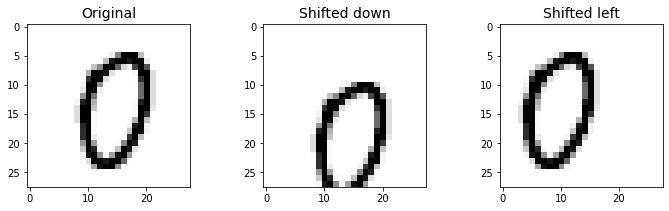

In [21]:
import matplotlib.pyplot as plt

image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [22]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [23]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [26]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_, n_jobs=-1)

In [29]:
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_jobs=-1, n_neighbors=4, weights='distance')

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 1시간 또는 그 이상 걸릴 수 있습니다. (실제 2분 정도 걸림)

In [32]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9763

## 3. 타이타닉 데이터셋 도전
https://www.kaggle.com/c/titanic  

- 승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표
- 훈련데이터와 테스트데이트는 분리되어 있음
- 최고 성능을 구현하는 모델을 만든는 것이 목적

In [1]:
import os
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv", "test.csv"):
        filepath = os.path.join(path, filename)
        if not os.path.isfile(filepath):
            print("Downloading", filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()   

In [2]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [4]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data['Pclass'].unique()

array([3, 1, 2], dtype=int64)

속성의 의미: 

- PassengerId: 각 승객의 고유 식별자  
- Survived: 목표feature(0:사망, 1:생존)  
- Pclass: 승객 등급. 1, 2, 3등석. *commnet: 일반 자료와 달리 승객 분류에 crew가 없음*  
- Name, Sex, Age  
- SibSp: 함께 탑승한 형제, 배우자의 수  
- Parch: 함께 탑승한 자녀, 부모의 수  
- Ticket: 티켓 아이디  
- Fare: 티켓 요금 (파운드)  
- Cabin: 객실 번호  
- Embarked: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)  

In [7]:
#  passenger ID를 인덱스로 이용 ---> 왜??

train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

SyntaxError: invalid syntax (3746528375.py, line 4)

### 기술 통계량

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- **목표변수 Survived**: 평균 38%, 40%에 가까워 모델 평가에 정확도를 사용해 괜찮을 것
- 평균 **Fare** 32.20 파운드라 그렇게 비싸보이지는 않습니다(아마 요금을 많이 반환해 주었기 때문일 것입니다)
- 평균 **Age**는 30보다 작습니다.

In [10]:
train_data["Survived"].value_counts() # 결과: 사망 549명, 생존 342명 

0    549
1    342
Name: Survived, dtype: int64

In [11]:
train_data["Survived"].value_counts(normalize = True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [12]:
train_data["Pclass"].value_counts().sort_index()  # 인덱스별로 sorting하는 방법

1    216
2    184
3    491
Name: Pclass, dtype: int64

In [13]:
train_data["Embarked"].value_counts() # C=Cherbourg, Q=Queenstown, S=Southampton

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### 전처리(Pipeline)결측치, 정규화, 원핫인코딩, 레이블
- 수치형: 
    - 결측치: 중간값으로 대체 (Pclass별로 중간값 또는 평균 이용도 가능)
    - 정규화 처리
- 범주형
    - 결측치: 최빈값 적용(?)
    - 원핫인코딩
- Cabin 열 삭제

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# 숫자형 파이프 라인

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [15]:
# 범주형 파이프 라인

from sklearn.preprocessing import OneHotEncoder
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [16]:
# 숫자형, 범주형 파이프라인 연결
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [17]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [18]:
X_train[1] # 결과: 범주형은 원핫 인코딩: Pclass 3, Sex 2, Embarked 3 열 생성

array([ 0.66386103,  0.43279337, -0.47367361,  0.78684529,  1.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  0.        ])

In [19]:
# 목표 변수(레이블)
y_train = train_data["Survived"]

### 훈련
- random forest

In [20]:
# random forest 훈련

from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# 성능(정확도)

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8092759051186016

In [22]:
# Support Vector Machine

from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

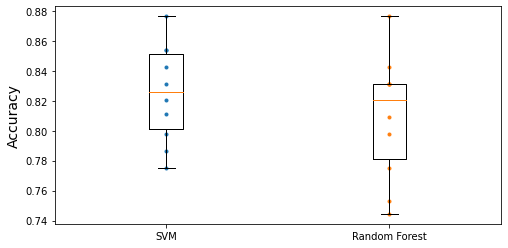

In [23]:
# 모댈 비교(Boxplot)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [24]:
# 특성(변수) 조정: 나이를 범주형으로
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


In [25]:
# 특성(변수) 조정: 가족수(친척 + 부모)
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [26]:
# 변수 통합 
num_attribs = ["RelativesOnboard", "Fare"]
cat_attribs = ["AgeBucket","Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [27]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
y_train = train_data["Survived"]

In [28]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.811498127340824

In [29]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8182022471910113

In [30]:
# 변수 통합 + 기존
num_attribs = ["Age", "SibSp", "RelativesOnboard", "Fare", "Parch"]
cat_attribs = ["AgeBucket","Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

In [31]:
X_train = preprocess_pipeline.fit_transform(train_data[num_attribs + cat_attribs])
y_train = train_data["Survived"]

In [32]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8025468164794006

In [33]:
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8294257178526842

변수 통합 + 기존 몇가지 적용하여도 정확도는 크개 변하지 않음
- rf : 80.92 / **81.15** / 80.25
- svm: 82.49 / 81.82 / **82.94**

*knn 또는 다른 머신러닝 모델은?*

In [40]:
# KNN 분류 / 그리드 탐색 
from sklearn.model_selection import GridSearchCV
param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]
# 훈련 
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=10, verbose=1, n_jobs=-1)
# grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=1, n_jobs=-1)
# 훈련
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

In [41]:
grid_search.best_params_

{'n_neighbors': 3, 'weights': 'uniform'}

In [42]:
grid_search.best_score_

0.8013732833957553

In [43]:
# SVM 분류 / 그리드 탐색
from sklearn.model_selection import GridSearchCV
param_grid = [{'gamma': ["auto", "scale"], 'kernel': ['rbf', 'linear']}]
# 훈련 
svm_clf = SVC()
grid_search = GridSearchCV(svm_clf, param_grid, cv=10, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_score_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
{'gamma': 'auto', 'kernel': 'rbf'}
0.8294257178526842


fare 변수의 정규화, cabin 변수 사용? ==> 전처리 방법: 별도 파일 전처리 부분 참조해서 해 보면? 

## 4. 스팸 필터 (코드 공부중...)

In [44]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()

In [45]:
fetch_spam_data()

In [46]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [48]:
print(len(ham_filenames))
print(len(spam_filenames))

2500
500


In [49]:
# 이메일 파싱
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [50]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [51]:
# 이메일 구성 샘플 보기
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [52]:
# 이메일 구성 샘플 보기
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40
